# SSIB analysis walk through
## To DO 0
1. Create a git repo
2. After each to do, commit and push your changes to the repo (I am going to look at this analysis using the git repo, I should see updates in this notebook at each commit corresponding to the to do)
3. Add the Rmd to the git repo as well. THE GIT REPO SHOULD NOT HAVE ANY DATA IN IT

# Notes
## Features
The X dataframe is your "features". Right now there are too many features for the number of subjects. A good rule of thumb is your features should be 10% or less than your number of samples (subjects). Since we are going to be doing training and testing, we need to limit the number of features to our final testing dataset
## Samples
This is the number of subjects in our dataset
## Targets
This is what we are trying to predict. Right now we are trying to predict the high and low SSB groups based on the features.

In [7]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [8]:
import statsmodels.api as sm
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score
from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
#from nilearn.input_data import NiftiLabelsMasker
#I got a warning that nilearn.input_data is deprecated, so I imported from nilearn.maskers instead
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
import numpy as np

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline

In [9]:
import networkx

# Load the data
Change the path as needed

In [10]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'
#Yana windows
#basepath = r'C:\Users\Yanko\OneDrive - University of Wyoming\Desktop - Copy\Lab\SSIB 2024'

^ Why are you working off the OneDrive :/

In [12]:
df = pd.read_csv(os.path.join(basepath,'data','matched111724.csv'))  
#df = pd.read_csv(os.path.join(basepath,'data','matched111724_centered_dum.csv'))  

# To DO 1
1. Get the number of subjects call them 'n'
## REDO 1
1. Use shape to get the number of subjects without hard coding

In [13]:
#1. gettig the n of subjects
# df.describe
# This isn't a great way to the number of subjects

2. Get a list of ROIs that include all the brain regions, sex, bmi_percentile, household income, and age  

In [14]:
#looking for columns location to gather them into list later
rois_0 = list(df.columns)

for i in rois_0:
    print(i, df.columns.get_loc(i))

collection_id 0
abcd_mx01_id 1
dataset_id 2
subjectkey 3
src_subject_id 4
demo_comb_income_v2 5
race 6
sex 7
bkfs_soda 8
interview_age 9
anthroheightcalc 10
rsfmri_c_ngd_ad_ngd_ad 11
rsfmri_c_ngd_ad_ngd_cgc 12
rsfmri_c_ngd_ad_ngd_ca 13
rsfmri_c_ngd_ad_ngd_dt 14
rsfmri_c_ngd_ad_ngd_dla 15
rsfmri_c_ngd_ad_ngd_fo 16
rsfmri_c_ngd_ad_ngd_n 17
rsfmri_c_ngd_ad_ngd_rspltp 18
rsfmri_c_ngd_ad_ngd_smh 19
rsfmri_c_ngd_ad_ngd_smm 20
rsfmri_c_ngd_ad_ngd_sa 21
rsfmri_c_ngd_ad_ngd_vta 22
rsfmri_c_ngd_ad_ngd_vs 23
rsfmri_c_ngd_cgc_ngd_ad 24
rsfmri_c_ngd_cgc_ngd_cgc 25
rsfmri_c_ngd_cgc_ngd_ca 26
rsfmri_c_ngd_cgc_ngd_dt 27
rsfmri_c_ngd_cgc_ngd_dla 28
rsfmri_c_ngd_cgc_ngd_fo 29
rsfmri_c_ngd_cgc_ngd_n 30
rsfmri_c_ngd_cgc_ngd_rspltp 31
rsfmri_c_ngd_cgc_ngd_smh 32
rsfmri_c_ngd_cgc_ngd_smm 33
rsfmri_c_ngd_cgc_ngd_sa 34
rsfmri_c_ngd_cgc_ngd_vta 35
rsfmri_c_ngd_cgc_ngd_vs 36
rsfmri_c_ngd_ca_ngd_ad 37
rsfmri_c_ngd_ca_ngd_cgc 38
rsfmri_c_ngd_ca_ngd_ca 39
rsfmri_c_ngd_ca_ngd_dt 40
rsfmri_c_ngd_ca_ngd_dla 41
rsfmri

**Call this list of ROIs "ROIS"**  

In [15]:
rois_0 = list(df.columns)


In [28]:
rois_0

['collection_id',
 'abcd_mx01_id',
 'dataset_id',
 'subjectkey',
 'src_subject_id',
 'demo_comb_income_v2',
 'race',
 'sex',
 'bkfs_soda',
 'interview_age',
 'anthroheightcalc',
 'rsfmri_c_ngd_ad_ngd_ad',
 'rsfmri_c_ngd_ad_ngd_cgc',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_

In [31]:
#Columns needed: 1,3,5:421,425
#Don't need the subject keys!
ROIS = []
ROIS.append(rois_0[5])
ROIS.append(rois_0[7])
for i in rois_0[11:-8]: #here need 422 to get 421 included! 
    ROIS.append(i)
    
# How can you do this without a loop?

ROIS.append(rois_0[-4])
ROIS

['demo_comb_income_v2',
 'sex',
 'rsfmri_c_ngd_ad_ngd_ad',
 'rsfmri_c_ngd_ad_ngd_cgc',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_c_ngd_ca_ngd_dt',
 'rsfmri_c_ngd_ca_ngd_dla',
 'rsfmri_c_ngd_ca_ngd_fo',
 'rsfmri_c_ngd_ca_ngd_n',
 'rsfmri_c_ngd_ca_ngd_rspltp',
 'rsfmri_c_ngd_c

3. Set sex to 0 for M and 1 for female  
4. Set ssb groups to low =0, medium = 1, and high = 2  
5. Drop the medium group  
6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list. 

In [32]:
#3. Set sex to 0 for M and 1 for female  
df.replace({'sex': {'F': 1, 'M': 0}}, inplace=True)

#4. Set ssb groups to low =0, medium = 1, and high = 2  
df.replace({'ssb_group': {'low': 0, 'high': 2}}, inplace=True)

#5. Drop the medium group  
df = df[df['ssb_group'] != "medium"]

#6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list.
X = df[ROIS]


In [33]:
# Transpose the DataFrame to make columns become rows
X_T = X.T
duplicates = X_T.duplicated(keep='first')
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

      demo_comb_income_v2  sex  rsfmri_c_ngd_ad_ngd_ad  \
0                       9    0                0.374677   
1                       9    1                0.316619   
2                       1    0                0.285115   
3                       8    1                0.346104   
4                       4    1                0.454593   
...                   ...  ...                     ...   
3695                    8    0                0.314078   
3696                    9    1                0.434439   
3697                    7    1                0.350479   
3698                   10    0                0.303789   
3699                    9    0                0.348108   

      rsfmri_c_ngd_ad_ngd_cgc  rsfmri_c_ngd_ad_ngd_ca  rsfmri_c_ngd_ad_ngd_dt  \
0                    0.156529               -0.021578               -0.096021   
1                    0.180278               -0.048049                0.008347   
2                    0.168481               -0.048336       

In [34]:
#Just a checkpoint to test for mistakes
X_cleaned.shape

(3700, 341)

## Why do we have to do the step above?

I am not sure why it's done this way, but I know the purpose of this actions. <br>
The model does not take anything except numbers, and we need a df of just numbers to make it run (we could include non-numerical cols (say, IDs) as index, but this would lead to extra changes in Grace's original script and hours of wasted time.) <br>
I don't know where duplicates come from.

# Where do the duplicates come from?

# To DO 2
1. Create a dataframe 'y' with only the targets
2. Check the number of each target group

In [35]:
# 1. Create a dataframe 'y' with only the targets
y = pd.to_numeric(df['ssb_group'])
#needed to convert to numeric because it has an object type by default

# 2. Check the number of each target group
target_counts = y.value_counts()
print("Number of subjects in each target group:")
print(target_counts)


Number of subjects in each target group:
2    1850
0    1850
Name: ssb_group, dtype: int64


# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences
-- In Test we will also have trainReg and testReg 
-- We need to train and test the signifance model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [37]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)


## What proportion of data is in:
1. X_train1?
2. X_train2?
3. X_test?

In [38]:
# Calculate proportions of data in each dataset
proportion_X_train1 = len(X_train1) / len(X_cleaned)
proportion_X_train2 = len(X_train2) / len(X_cleaned)
proportion_X_test = len(X_test) / len(X_cleaned)

print("Proportion of data in X_train1:", proportion_X_train1)
print("Proportion of data in X_train2:", proportion_X_train2)
print("Proportion of data in X_test:", proportion_X_test)

Proportion of data in X_train1: 0.5624324324324325
Proportion of data in X_train2: 0.18756756756756757
Proportion of data in X_test: 0.25


In [39]:
len1 = len(X_train1)
len2 = len(X_train2)
len3 = len(X_test)

print("len(X_train1):", len1)
print("len(X_train2):", len2)
print("len(X_test):", len3)

len(X_train1): 2081
len(X_train2): 694
len(X_test): 925


X_cleaned is a pandas df, I have no idea why len works to find the number of rows in a df, when it's a function to tell the length of a list. But it really works. 

# To DO 3
Now we are going run the model. We are going to use an anova filter with a SVC linear kernel. 
1. Run the pipeline with the following parameters
- Make a list of anova__K parameters with a maximum value that is 10% of our X_test sample in intervals of 10 <br>
For example if our max was 1000 we would have a list from 10 to 1000 by 10 (10, 20, 30...1000)
-- call this list 'ANOVAK'
- Make a list of svc__C parameters that include 0.1, 1, 10, 100
-- call this list 'svcC'
2. With your lists run the pipeline below


In [40]:
#1. Define the maximum value for ANOVA K parameter (10% of X_test sample)
max_anova_k = int(len(X_test) * 0.1) #made it an integer, cause it's 92.7 and float can't be used in the script below

# Make a list of ANOVA K parameters with intervals of 10
ANOVAK = list(range(10, max_anova_k+1, 10)) #range 10-max_anova_k (+1 bcs otherwise the last number won't be included to the range), steps - 10
ANOVAK

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [41]:
#2. Make a list of svc__C parameters that include 0.1, 1, 10, 100
#call this list 'svcC'
svcC = [0.1, 1, 10, 100]

## Why are we using an ANOVA filter?

To select features based on whether they are significant or not. <br>
These features will be used as predictor values in our model to classify the ssb group.

## Why use the ANOVA and not any other type?

In [ ]:
## THIS IS THE PIPELINE ##

anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# To DO 4
1. Look at the "best parameters". Based on this narrow your ANOVAK and svcC lists. The ANOVAK should have the best value and the 10 digits around it. For example if the best value was 20, the next ANOVAK list should be [15,16,17,18,19,20,21,22,23,24,25]. Do the same with the best value of svcC.
2. Run the loop below (this will take a while) with your new parameters
## What is the optimum number of features and what is the optimum svc C based on your loop?

Best parameters: {'anova__k': 60, 'svc__C': 0.1}

Best cross-validation score: 0.5510857563489142


In [17]:
ANOVAK = list(range(55, 66, 1)) #range 55-65, steps - 1
print(ANOVAK)
print(len(ANOVAK))

[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
11


In [ ]:
#the range function does not work with integers, so I created a loop
# The range function only works with integers, it doesn't work with floats
#and cleaned the svcC list to fill with necessary numbers
svcC = []
for i in range(75, 126, 5):
    svcC.append(i/1000.0)
print(svcC)
print(len(svcC))

In [23]:
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

bestK = []
bestC = []
for i in range(5):
    print(i)
    # Setup GridSearchCV
    grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
    grid_search.fit(X_train1, y_train1)
    bestK.append(grid_search.best_params_['anova__k'])
    bestC.append(grid_search.best_params_['svc__C'])

0
1
2
3
4


# To DO 5
1. Using the best parameters run the code below 
## Are these the best parameters or just the last parameters in from the best_pipeline object

In [24]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('anova', SelectKBest(k=58)),
                ('svc', SVC(C=0.1, kernel='linear'))])

# To DO 6
1. Get the accuracy score
2. Look at the confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## What is the accuracy score telling us?

The accuracy score is 0.5330459770114943. <br> 
It means that our model predicts correctly in 53.3% cases. <br>
Still, it's considered not the perfect indicator of the model performance (especially if the groups are unbalanced, which I believe is our case, considering how we had to drop the bmi% groups + we have household income groups, which also probably aren't very balanced.  

The groups are only refering to the target groups. Also our data is pretty well matched. So why isn't the model that accurate? 

## What is the confusion matrix telling us? 
The confusion matrix is a matrix of numbers that tell us where a model gets confused. Say, of 4 classes, what if the model is predicting 1 class wrong and that's driving the accuracy score down? <br> 
So, confusion matrix gives a more detailed breakdown of the model's performance, showing how many instances were correctly or incorrectly classified, and in what way. Here's what each part of the matrix is telling us:

- **<u>0-0 True Negative (Top Left, 0.76)</u>**: The proportion of actual negatives (low ssb) that were correctly identified by the model. 76% is a pretty good number, it means that the model is relatively good at identifying the low ssb group.
- **<u> 1-0 False Positive (Top Right, 0.24)</u>**: The proportion of actual negatives (low ssb) that were incorrectly identified as positives (high ssb). This is a type I error.
- **<u> 0-1 False Negative (Bottom Left, 0.67)</u>**: The proportion of actual positives (high ssb) that were incorrectly identified as negatives (low ssb). This is a type II error and is quite high, indicating that the model often fails to identify positive instances (high ssb).
- **<u> 1-1 True Positive (Bottom Right, 0.33)</u>**: The proportion of actual positives (high ssb) that were correctly identified by the model. <br> 33% value is low, which means that our model is not very effective at correctly identifying positive instances (high ssb).

## 0s - low ssb group, 1s - high ssb group 

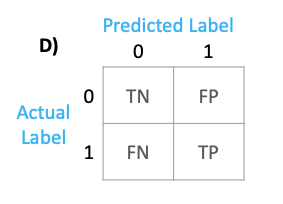

## Which target is classified the best? 

Low ssb groups

# To DO 7
1. Get the best parameters from the best model using the code below
2. Get the features as columns

In [25]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


Best parameters found by GridSearchCV: {'anova__k': 58, 'svc__C': 0.1}
Best model: Pipeline(steps=[('anova', SelectKBest(k=58)),
                ('svc', SVC(C=0.1, kernel='linear'))])


In [26]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()
selected_columns = X_train.columns[selected_features_mask]


## What features best describe the targets?


In [ ]:
selected_columns

## How are the features similar or not? 

They are all brain regions, there's no bmi or ses

# Regression
Now we are going to try to predict the SSB intake at year 2 using the features from year 1

# To DO 8
1. Subset the X_test data so that it contains only the columns selected from the feature selection above call this X_regression
2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
3. Run a binary logistic model

In [27]:
# 1.Subset the X_test data to contain only the columns selected from the feature selection
X_regression = X_test[selected_columns]

#2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X_regression, y_test, test_size=0.2, random_state=42)

In [ ]:
X_regression

In [34]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
#accuracyReg = accuracy_score(y_testReg, y_predReg)
#print(f"Accuracy: {accuracyReg}")

# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

# To DO 9
1. Make a dataframe of the coefficeients and have the features at the columns names
2. Add an intercept column
3. Plot the figure

In [35]:
# 1. Make a dataframe of the coefficients and have the features as the column names
coeff_df = pd.DataFrame(coefficients, columns=X_regression.columns)

# 2. Add an intercept column
coeff_df['intercept'] = intercepts

coeff_df

,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_ca_ngd_smm,rsfmri_c_ngd_ca_ngd_vta,rsfmri_c_ngd_dla_ngd_smm,rsfmri_c_ngd_dla_ngd_vta,rsfmri_c_ngd_smh_ngd_smh,rsfmri_c_ngd_smh_ngd_smm,...,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_sa_scs_ptlh,rsfmri_cor_ngd_vta_scs_crcxlh,rsfmri_cor_ngd_vta_scs_thplh,rsfmri_cor_ngd_vta_scs_aalh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_aarh,intercept
0,-0.272341,0.222602,0.636042,-0.010397,0.520303,0.719428,0.020213,-0.647628,0.184846,0.610936,...,-0.436786,-0.28992,1.14366,0.28319,0.100589,-0.626532,-0.176039,0.088996,-0.240991,-0.428113


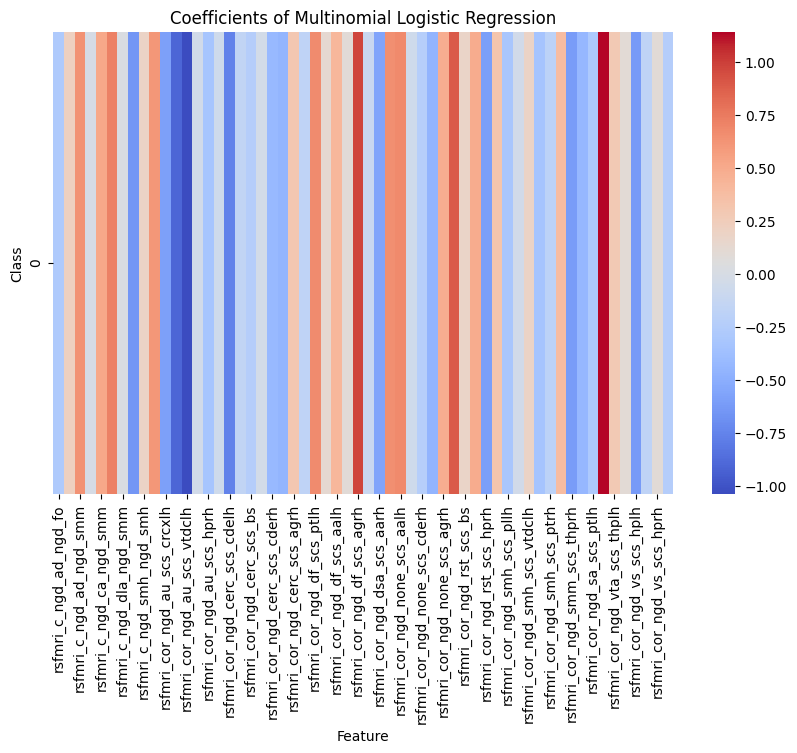

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

# Summary
We now have done a basic logistic regression, but we want to see what features are signigicant predictors of SSB intake. We will use a different logistic regression package through statsmodels to get more details

In [37]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_test_reg_sm = sm.add_constant(X_testReg)


/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# To DO 10
1. Replace 2 with 1 in the y_testReg target
2. Run the model

In [38]:
# 1. Replace 2 with 1 in the y_testReg target
y_testReg = y_testReg.replace(2, 1)


In [39]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm)
result = logit_model.fit()
# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527722
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  186
Model:                          Logit   Df Residuals:                      127
Method:                           MLE   Df Model:                           58
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                  0.2371
Time:                        14:07:00   Log-Likelihood:                -98.156
converged:                       True   LL-Null:                       -128.66
Covariance Type:            nonrobust   LLR p-value:                    0.3686
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.8427      1.239      0.680     

In [40]:
result.params

const                              0.842724
rsfmri_c_ngd_ad_ngd_fo           -12.534623
rsfmri_c_ngd_ad_ngd_smh           -0.518308
rsfmri_c_ngd_ad_ngd_smm           -3.604744
rsfmri_c_ngd_ad_ngd_vs             6.062062
rsfmri_c_ngd_ca_ngd_smm           -1.437187
rsfmri_c_ngd_ca_ngd_vta           -5.346147
rsfmri_c_ngd_dla_ngd_smm           5.395949
rsfmri_c_ngd_dla_ngd_vta          -4.419379
rsfmri_c_ngd_smh_ngd_smh          -3.664887
rsfmri_c_ngd_smh_ngd_smm           1.659536
rsfmri_cor_ngd_au_scs_crcxlh      -0.892715
rsfmri_cor_ngd_au_scs_aalh         2.667386
rsfmri_cor_ngd_au_scs_vtdclh       0.403611
rsfmri_cor_ngd_au_scs_ptrh        -1.278411
rsfmri_cor_ngd_au_scs_hprh         1.037199
rsfmri_cor_ngd_au_scs_vtdcrh       9.216080
rsfmri_cor_ngd_cerc_scs_cdelh     -5.474711
rsfmri_cor_ngd_cerc_scs_ptlh       4.491193
rsfmri_cor_ngd_cerc_scs_bs        -3.137211
rsfmri_cor_ngd_cerc_scs_aglh      -5.128009
rsfmri_cor_ngd_cerc_scs_cderh     -1.768373
rsfmri_cor_ngd_cerc_scs_hprh    

## What features are significantly related to SSB intake?

In [41]:
p_values = result.pvalues
significant_features = p_values[p_values < 0.05]
print(significant_features)

rsfmri_cor_ngd_cerc_scs_hprh      0.010505
rsfmri_cor_ngd_cerc_scs_vtdcrh    0.017187
rsfmri_cor_ngd_df_scs_aalh        0.026534
rsfmri_cor_ngd_none_scs_aalh      0.042448
rsfmri_cor_ngd_sa_scs_thplh       0.014235
dtype: float64


In [42]:
# Making predictions
predictions = result.predict(X_test_reg_sm)
# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)
# The real target assignments
real = y_testReg.to_numpy()

# To DO 11
1. Make a dataframe with two columns 'real' (the actual target classes) and 'pred' (the predicted target classes)
2. Use the jaccard score to measure the accuracy of the model

In [43]:
# Create a dataframe with two columns 'real' and 'pred'
dfPrevReal = pd.DataFrame({
    'real': real,
    'pred': class_predictions
})

In [44]:
jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)


Jaccard Similarity Score: 0.6


In [45]:
## Get getting the odds ratios

In [46]:
np.exp(result.params)


const                             2.322685e+00
rsfmri_c_ngd_ad_ngd_fo            3.599835e-06
rsfmri_c_ngd_ad_ngd_smh           5.955273e-01
rsfmri_c_ngd_ad_ngd_smm           2.719442e-02
rsfmri_c_ngd_ad_ngd_vs            4.292595e+02
rsfmri_c_ngd_ca_ngd_smm           2.375953e-01
rsfmri_c_ngd_ca_ngd_vta           4.766480e-03
rsfmri_c_ngd_dla_ngd_smm          2.205113e+02
rsfmri_c_ngd_dla_ngd_vta          1.204171e-02
rsfmri_c_ngd_smh_ngd_smh          2.560707e-02
rsfmri_c_ngd_smh_ngd_smm          5.256870e+00
rsfmri_cor_ngd_au_scs_crcxlh      4.095425e-01
rsfmri_cor_ngd_au_scs_aalh        1.440227e+01
rsfmri_cor_ngd_au_scs_vtdclh      1.497222e+00
rsfmri_cor_ngd_au_scs_ptrh        2.784794e-01
rsfmri_cor_ngd_au_scs_hprh        2.821302e+00
rsfmri_cor_ngd_au_scs_vtdcrh      1.005756e+04
rsfmri_cor_ngd_cerc_scs_cdelh     4.191441e-03
rsfmri_cor_ngd_cerc_scs_ptlh      8.922781e+01
rsfmri_cor_ngd_cerc_scs_bs        4.340369e-02
rsfmri_cor_ngd_cerc_scs_aglh      5.928355e-03
rsfmri_cor_ng

# Double check
Issue with the odds ratios from statsModels. They have impossibily high values. Possibily due to scaling. However, the brain data is all scaled (I believe). Will need to check this. Going to run the model in statsModels and scikit learn to see what is going on. 

## Checking odds ratios

### Prepro check
Going to scale the data just too see if that helps. Also will check the varience inflation factor to see if that is an issue.

In [51]:
X_testReg

,rsfmri_c_ngd_ad_ngd_fo,rsfmri_c_ngd_ad_ngd_smh,rsfmri_c_ngd_ad_ngd_smm,rsfmri_c_ngd_ad_ngd_vs,rsfmri_c_ngd_ca_ngd_smm,rsfmri_c_ngd_ca_ngd_vta,rsfmri_c_ngd_dla_ngd_smm,rsfmri_c_ngd_dla_ngd_vta,rsfmri_c_ngd_smh_ngd_smh,rsfmri_c_ngd_smh_ngd_smm,...,rsfmri_cor_ngd_smm_scs_thprh,rsfmri_cor_ngd_sa_scs_thplh,rsfmri_cor_ngd_sa_scs_ptlh,rsfmri_cor_ngd_vta_scs_crcxlh,rsfmri_cor_ngd_vta_scs_thplh,rsfmri_cor_ngd_vta_scs_aalh,rsfmri_cor_ngd_vs_scs_hplh,rsfmri_cor_ngd_vs_scs_plrh,rsfmri_cor_ngd_vs_scs_hprh,rsfmri_cor_ngd_vs_scs_aarh
4990,0.000144,0.068887,0.197993,-0.023126,-0.042877,-0.183845,-0.028767,-0.205254,0.236221,-0.081918,...,-0.064467,-0.058996,-0.087883,-0.012440,-0.228218,-0.023215,0.027261,0.038841,-0.019621,-0.104365
1420,-0.044571,0.035871,0.114620,0.015332,-0.127352,-0.112936,-0.029999,-0.121341,0.191234,0.048529,...,0.086561,0.180868,0.042194,-0.007000,0.018355,-0.038534,0.018768,0.026832,0.083880,0.034894
4632,-0.045564,0.177869,0.224426,0.058579,-0.206003,-0.062955,0.010362,-0.014823,0.209273,0.104048,...,0.130297,-0.025963,0.149486,0.161303,-0.165725,0.002614,-0.123188,-0.086754,0.030115,0.076626
4825,-0.000027,0.082809,0.099717,-0.057643,-0.138724,-0.115803,0.013814,-0.148553,0.242418,0.013882,...,0.047680,0.121542,0.008127,-0.070705,-0.161523,0.027254,-0.037313,-0.072199,0.044305,-0.029183
4747,-0.052189,0.129282,0.178476,0.009857,0.014040,-0.037422,-0.001059,-0.076007,0.247887,0.118913,...,0.110552,0.262127,-0.045283,0.067172,-0.184407,0.083018,0.103457,0.026020,0.067539,-0.063867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,-0.011716,0.101741,0.300961,-0.024935,-0.021554,-0.110488,0.033372,-0.048685,0.265880,0.159759,...,0.261039,0.365446,-0.035849,-0.168835,-0.092638,-0.161030,0.150978,0.127057,0.171157,-0.001823
3983,-0.023892,0.052279,0.227208,-0.104314,-0.146382,-0.079369,-0.000007,-0.115619,0.247385,0.020320,...,0.075005,0.059169,-0.007114,0.021217,-0.203035,0.038067,0.140047,0.015407,0.074823,-0.033732
676,-0.110359,0.190083,0.268866,0.059131,-0.089988,-0.112036,0.026618,0.006295,0.314462,0.264197,...,0.128403,-0.012581,0.036123,0.112173,-0.212964,0.043532,0.139795,-0.223685,-0.083364,0.061681
4049,-0.064074,0.058339,0.092887,0.000357,-0.023007,-0.132479,0.074630,-0.198216,0.220537,0.065692,...,0.051914,0.110763,0.035534,-0.048138,0.064457,0.025392,0.036035,-0.016014,0.087228,0.009466


In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_testReg)

In [52]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_testReg.columns)


In [53]:
variance = X_scaled_df.var()
print(variance)  # Low variance columns might be problematic

rsfmri_c_ngd_ad_ngd_fo            1.005405
rsfmri_c_ngd_ad_ngd_smh           1.005405
rsfmri_c_ngd_ad_ngd_smm           1.005405
rsfmri_c_ngd_ad_ngd_vs            1.005405
rsfmri_c_ngd_ca_ngd_smm           1.005405
rsfmri_c_ngd_ca_ngd_vta           1.005405
rsfmri_c_ngd_dla_ngd_smm          1.005405
rsfmri_c_ngd_dla_ngd_vta          1.005405
rsfmri_c_ngd_smh_ngd_smh          1.005405
rsfmri_c_ngd_smh_ngd_smm          1.005405
rsfmri_cor_ngd_au_scs_crcxlh      1.005405
rsfmri_cor_ngd_au_scs_aalh        1.005405
rsfmri_cor_ngd_au_scs_vtdclh      1.005405
rsfmri_cor_ngd_au_scs_ptrh        1.005405
rsfmri_cor_ngd_au_scs_hprh        1.005405
rsfmri_cor_ngd_au_scs_vtdcrh      1.005405
rsfmri_cor_ngd_cerc_scs_cdelh     1.005405
rsfmri_cor_ngd_cerc_scs_ptlh      1.005405
rsfmri_cor_ngd_cerc_scs_bs        1.005405
rsfmri_cor_ngd_cerc_scs_aglh      1.005405
rsfmri_cor_ngd_cerc_scs_cderh     1.005405
rsfmri_cor_ngd_cerc_scs_hprh      1.005405
rsfmri_cor_ngd_cerc_scs_agrh      1.005405
rsfmri_cor_

In [54]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
X_scaled_df = pd.DataFrame(X_scaled, columns=X_testReg.columns)  # Convert to DataFrame if necessary
X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_scaled_df_with_const.values, i) 
                   for i in range(X_scaled_df_with_const.shape[1])], 
                  index=X_scaled_df_with_const.columns)

print(vifs)

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


const                              1.000000
rsfmri_c_ngd_ad_ngd_fo             3.535873
rsfmri_c_ngd_ad_ngd_smh            7.061025
rsfmri_c_ngd_ad_ngd_smm            2.923439
rsfmri_c_ngd_ad_ngd_vs             3.352462
rsfmri_c_ngd_ca_ngd_smm            2.546263
rsfmri_c_ngd_ca_ngd_vta            2.263008
rsfmri_c_ngd_dla_ngd_smm           2.071255
rsfmri_c_ngd_dla_ngd_vta           2.067532
rsfmri_c_ngd_smh_ngd_smh           4.661602
rsfmri_c_ngd_smh_ngd_smm           4.863620
rsfmri_cor_ngd_au_scs_crcxlh       6.855128
rsfmri_cor_ngd_au_scs_aalh         7.052674
rsfmri_cor_ngd_au_scs_vtdclh       4.255025
rsfmri_cor_ngd_au_scs_ptrh        10.870462
rsfmri_cor_ngd_au_scs_hprh         2.517135
rsfmri_cor_ngd_au_scs_vtdcrh       3.632549
rsfmri_cor_ngd_cerc_scs_cdelh      7.242052
rsfmri_cor_ngd_cerc_scs_ptlh       7.643131
rsfmri_cor_ngd_cerc_scs_bs         4.597144
rsfmri_cor_ngd_cerc_scs_aglh      12.427502
rsfmri_cor_ngd_cerc_scs_cderh      5.473258
rsfmri_cor_ngd_cerc_scs_hprh    

In [55]:
correlation_matrix = X_scaled_df.corr()


In [56]:
# Set the threshold for high correlation
threshold = 0.8

# Create a boolean mask for values above the threshold
high_corr_mask = np.abs(correlation_matrix) > threshold

# Mask the diagonal and lower triangle
mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)

# Combine masks
final_mask = high_corr_mask & mask_upper_triangle


/var/folders/02/zfp2v0gd46j44wl8qx8jxjtr0000gn/T/ipykernel_32128/2146447036.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)


In [57]:
# Apply mask to the correlation matrix
high_corr_pairs = correlation_matrix.where(final_mask)

# Stack the matrix and reset index to get pair-wise correlation in a readable format
stacked_corr_pairs = high_corr_pairs.stack().reset_index()
stacked_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

print(stacked_corr_pairs)

                      Feature 1                      Feature 2  Correlation
0    rsfmri_cor_ngd_au_scs_ptrh  rsfmri_cor_ngd_rst_scs_crcxrh     0.840632
1  rsfmri_cor_ngd_cerc_scs_aglh    rsfmri_cor_ngd_smh_scs_pllh     0.821629
2  rsfmri_cor_ngd_cerc_scs_hprh   rsfmri_cor_ngd_smh_scs_cderh     0.860417


Need to drop highly correlated columns
* rsfmri_cor_ngd_au_scs_ptrh = Average correlation between auditory network and ASEG ROI right-putamen
* rsfmri_cor_ngd_rst_scs_crcxrh = Average correlation between retrosplenial temporal network and ASEG ROI right-cerebellum-cortex
* rsfmri_cor_ngd_cerc_scs_aglh = Average correlation between cingulo-opercular network and ASEG ROI left-amygdala
* rsfmri_cor_ngd_smh_scs_pllh = Average correlation between sensorimotor hand network and ASEG ROI left-pallidum
* rsfmri_cor_ngd_cerc_scs_hprh = Average correlation between cingulo-opercular network and ASEG ROI right-hippocampus
* rsfmri_cor_ngd_smh_scs_cderh = Average correlation between sensorimotor hand network and ASEG ROI right-caudate
Based on this list above we have some interest high correlations. I want to keep areas previously associated in the literature. 
## Keep
* rsfmri_cor_ngd_au_scs_ptrh = Average correlation between auditory network and ASEG ROI right-putamen
* rsfmri_cor_ngd_smh_scs_cderh = Average correlation between sensorimotor hand network and ASEG ROI right-caudate
* rsfmri_cor_ngd_smh_scs_pllh = Average correlation between sensorimotor hand network and ASEG ROI left-pallidum <- chose to keep since I dropped the other sensorimotor hand
## Drop
* rsfmri_cor_ngd_rst_scs_crcxrh = Average correlation between retrosplenial temporal network and ASEG ROI right-cerebellum-cortex
* rsfmri_cor_ngd_cerc_scs_hprh = Average correlation between cingulo-opercular network and ASEG ROI right-hippocampus <- this was a tough one, may do the analysis with both at some point
* rsfmri_cor_ngd_cerc_scs_aglh = Average correlation between cingulo-opercular network and ASEG ROI left-amygdala


In [58]:
columns_to_drop_list = ['rsfmri_cor_ngd_rst_scs_crcxrh','rsfmri_cor_ngd_cerc_scs_hprh','rsfmri_cor_ngd_cerc_scs_aglh']

In [59]:
X_scaled_df_reduced = X_scaled_df.drop(columns=columns_to_drop_list)


In [60]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
#X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)  # Convert to DataFrame if necessary
#X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_scaled_df_reduced.values, i) 
                   for i in range(X_scaled_df_reduced.shape[1])], 
                  index=X_scaled_df_reduced.columns)

print(vifs)

rsfmri_c_ngd_ad_ngd_fo            3.532466
rsfmri_c_ngd_ad_ngd_smh           6.921139
rsfmri_c_ngd_ad_ngd_smm           2.854010
rsfmri_c_ngd_ad_ngd_vs            3.196074
rsfmri_c_ngd_ca_ngd_smm           2.315055
rsfmri_c_ngd_ca_ngd_vta           2.240789
rsfmri_c_ngd_dla_ngd_smm          2.050592
rsfmri_c_ngd_dla_ngd_vta          1.957940
rsfmri_c_ngd_smh_ngd_smh          4.614429
rsfmri_c_ngd_smh_ngd_smm          4.685207
rsfmri_cor_ngd_au_scs_crcxlh      5.446490
rsfmri_cor_ngd_au_scs_aalh        6.053118
rsfmri_cor_ngd_au_scs_vtdclh      4.059833
rsfmri_cor_ngd_au_scs_ptrh        7.755670
rsfmri_cor_ngd_au_scs_hprh        2.408988
rsfmri_cor_ngd_au_scs_vtdcrh      3.627312
rsfmri_cor_ngd_cerc_scs_cdelh     7.007783
rsfmri_cor_ngd_cerc_scs_ptlh      6.850042
rsfmri_cor_ngd_cerc_scs_bs        3.787980
rsfmri_cor_ngd_cerc_scs_cderh     5.362891
rsfmri_cor_ngd_cerc_scs_agrh      5.516186
rsfmri_cor_ngd_cerc_scs_vtdcrh    4.604403
rsfmri_cor_ngd_df_scs_ptlh        2.953801
rsfmri_cor_

In [61]:
# Assuming df_reduced is your DataFrame after removing highly correlated columns
# and y_testReg is your target variable

# Reset index for the predictors (features)
X_aligned = X_scaled_df_reduced.reset_index(drop=True)

# Reset index for the target variable
y_aligned = y_testReg.reset_index(drop=True)

# Now, both X_aligned and y_aligned have aligned indices

### StatsModels

In [62]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_aligned_sm = sm.add_constant(X_aligned)

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [63]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_aligned, X_aligned)

In [64]:
result = logit_model.fit() # error because of signularity
# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.550217
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  186
Model:                          Logit   Df Residuals:                      131
Method:                           MLE   Df Model:                           54
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                  0.2045
Time:                        14:09:39   Log-Likelihood:                -102.34
converged:                       True   LL-Null:                       -128.66
Covariance Type:            nonrobust   LLR p-value:                    0.5273
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
rsfmri_c_ngd_ad_ngd_fo            -0.6007      0.338     -1.778     

In [65]:
# Fit the model with regularization
# Here we demonstrate using L1 regularization (Lasso)
# You can adjust L1 vs. L2 regularization via the L1_wt parameter (0 for L2, 1 for L1)
# alpha controls the strength of regularization (smaller values indicate stronger regularization)
result_regularized = logit_model.fit_regularized(method='l1', alpha=1, L1_wt=0)



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6124756102571839
            Iterations: 83
            Function evaluations: 84
            Gradient evaluations: 83


In [66]:
# Coefficients
coef = result_regularized.params
print("Odds Ratio:", np.exp(coef))
#Very close to the sklearn

Odds Ratio: rsfmri_c_ngd_ad_ngd_fo            0.684614
rsfmri_c_ngd_ad_ngd_smh           0.825277
rsfmri_c_ngd_ad_ngd_smm           0.985003
rsfmri_c_ngd_ad_ngd_vs            1.000000
rsfmri_c_ngd_ca_ngd_smm           0.867017
rsfmri_c_ngd_ca_ngd_vta           0.798185
rsfmri_c_ngd_dla_ngd_smm          1.232011
rsfmri_c_ngd_dla_ngd_vta          0.852933
rsfmri_c_ngd_smh_ngd_smh          0.905851
rsfmri_c_ngd_smh_ngd_smm          1.000000
rsfmri_cor_ngd_au_scs_crcxlh      1.000000
rsfmri_cor_ngd_au_scs_aalh        1.000000
rsfmri_cor_ngd_au_scs_vtdclh      0.981380
rsfmri_cor_ngd_au_scs_ptrh        0.899444
rsfmri_cor_ngd_au_scs_hprh        1.181066
rsfmri_cor_ngd_au_scs_vtdcrh      1.321903
rsfmri_cor_ngd_cerc_scs_cdelh     0.855939
rsfmri_cor_ngd_cerc_scs_ptlh      1.330542
rsfmri_cor_ngd_cerc_scs_bs        1.024712
rsfmri_cor_ngd_cerc_scs_cderh     0.804532
rsfmri_cor_ngd_cerc_scs_agrh      1.542767
rsfmri_cor_ngd_cerc_scs_vtdcrh    1.637601
rsfmri_cor_ngd_df_scs_ptlh        1.048023

In [69]:
original_coefs = result_regularized.params


In [72]:
# Number of bootstrap iterations
n_bootstraps = 1000
n_permutations = 1000
# Initialize array to store bootstrapped coefficients
bootstrap_coefs = np.zeros((n_bootstraps, X_aligned.shape[1]))
n_features = X_aligned.shape[1]

#### Getting the p value

In [73]:
# y_aligned, X_aligned
# Assuming X is your predictors matrix and y is the target variable
n_features = X_aligned.shape[1]

# Initialize an array to store permuted coefficients
permuted_coefs = np.zeros((n_permutations, n_features))

for i in range(n_permutations):
    print(i)
    # Permute the target variable
    y_permuted = np.random.permutation(y_aligned)
    
    # Fit the model with the permuted target
    model_permuted = sm.Logit(y_permuted, X_aligned)
    result_permuted = model_permuted.fit_regularized(method='l1', alpha=1, L1_wt=0, disp=0)  # disp=0 suppresses output
    
    # Store the coefficients from the permuted model
    permuted_coefs[i, :] = result_permuted.params

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Getting confidence intervals

In [85]:
for i in range(n_bootstraps):
    print(i)
    # Resample the dataset with replacement
    X_resampled, y_resampled = resample(X_aligned, y_aligned)
    
    
    # Fit the model on the resampled dataset
    model_resampled = sm.Logit(y_resampled, X_resampled)
    result_resampled = model_resampled.fit_regularized(method='l1', alpha=1, L1_wt=0, disp=0)  # Turn off verbose output
    
    # Store the coefficients
    bootstrap_coefs[i, :] = result_resampled.params

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
# Initialize an empty dictionary to store p-values with coefficient names
p_values_with_names = {}

for i, coef_name in enumerate(original_coefs.index):
    # Calculate the empirical p-value for each coefficient
    p_value = np.mean(np.abs(permuted_coefs[:, i]) >= np.abs(original_coefs[i]))
    # Store the p-value with the corresponding coefficient name
    p_values_with_names[coef_name] = p_value


In [87]:
# Calculate the 2.5th and 97.5th percentiles for each coefficient
lower_bounds = np.percentile(bootstrap_coefs, 2.5, axis=0)
upper_bounds = np.percentile(bootstrap_coefs, 97.5, axis=0)

# Assuming your model's coefficients are stored in a pandas Series for easy handling
coef_names = result_regularized.params.index
ci_df = pd.DataFrame({'odds ratio': np.exp(result_regularized.params.values),
                      'lower_ci': lower_bounds,
                      'upper_ci': upper_bounds,
                     'bootP':list(p_values_with_names.values())}, index=coef_names)

print(ci_df)

                                odds ratio  lower_ci  upper_ci  bootP
rsfmri_c_ngd_ad_ngd_fo            0.684614 -1.188795  0.000000  0.103
rsfmri_c_ngd_ad_ngd_smh           0.825277 -1.006939  0.389308  0.341
rsfmri_c_ngd_ad_ngd_smm           0.985003 -0.660499  0.399286  0.769
rsfmri_c_ngd_ad_ngd_vs            1.000000 -0.563380  0.741019  1.000
rsfmri_c_ngd_ca_ngd_smm           0.867017 -0.851889  0.326216  0.443
rsfmri_c_ngd_ca_ngd_vta           0.798185 -0.912810  0.213320  0.251
rsfmri_c_ngd_dla_ngd_smm          1.232011 -0.261156  0.864825  0.264
rsfmri_c_ngd_dla_ngd_vta          0.852933 -0.791763  0.297708  0.405
rsfmri_c_ngd_smh_ngd_smh          0.905851 -1.022922  0.354950  0.538
rsfmri_c_ngd_smh_ngd_smm          1.000000 -0.772795  0.744782  1.000
rsfmri_cor_ngd_au_scs_crcxlh      1.000000 -0.802161  0.798526  1.000
rsfmri_cor_ngd_au_scs_aalh        1.000000 -0.812005  0.529111  1.000
rsfmri_cor_ngd_au_scs_vtdclh      0.981380 -0.816824  0.568504  0.711
rsfmri_cor_ngd_au_sc

In [88]:
ci_df.sort_values('bootP', ascending=True)

,odds ratio,lower_ci,upper_ci,bootP
rsfmri_cor_ngd_sa_scs_thplh,0.571797,-1.561156,0.000000,0.052
rsfmri_cor_ngd_vta_scs_crcxlh,0.678088,-1.129200,0.049531,0.073
rsfmri_cor_ngd_cerc_scs_vtdcrh,1.637601,0.000000,1.618946,0.091
rsfmri_c_ngd_ad_ngd_fo,0.684614,-1.188795,0.000000,0.103
rsfmri_cor_ngd_df_scs_aarh,0.666792,-1.117896,0.048551,0.117
rsfmri_cor_ngd_cerc_scs_agrh,1.542767,-0.013818,1.353606,0.130
rsfmri_cor_ngd_sa_scs_ptlh,1.397792,-0.092357,1.123847,0.151
rsfmri_cor_ngd_none_scs_cderh,0.711300,-1.225009,0.000000,0.182
rsfmri_cor_ngd_df_scs_aalh,1.383503,-0.141175,1.231284,0.198
rsfmri_cor_ngd_au_scs_vtdcrh,1.321903,-0.173874,0.982218,0.244


In [101]:
dd1 = pd.read_csv(os.path.join(basepath,'data','abcd_betnet02.csv'))  

In [102]:
dd2 = pd.read_csv(os.path.join(basepath,'data','mrirscor02.csv'))  

In [103]:
data_dictionary = dict(zip(dd1['ElementName'], dd1['ElementDescription']))


In [104]:
data_dictionary2 = dict(zip(dd2['ElementName'], dd2['ElementDescription']))


In [113]:
ci_df_renamed = ci_df.rename(index=data_dictionary)

In [114]:
ci_df_renamed = ci_df_renamed.rename(index=data_dictionary2)

In [116]:
ci_df_renamed  = ci_df_renamed .reset_index()

In [117]:
# Regular expression to match any text after "between" and "and", accounting for variability
pattern = r'Average correlation between (?P<Network1>[\w-]+) and (?P<Network2>[\w\s-]+)'

ci_df_renamed [['Network1', 'Network2']] = ci_df_renamed ['index'].str.extract(pattern)

In [162]:
ci_df_renamed['Network2'] = ci_df_renamed['Network2'].str.replace('ASEG ROI ', '', regex=False)


In [175]:
ci_df_renamed['Network2'] = ci_df_renamed['Network2'].str.replace('-network', '', regex=False)


In [177]:
ci_df_renamed['Network1'] = ci_df_renamed['Network1'].str.replace('-network', '', regex=False)


In [120]:
import networkx as nx

In [179]:

G = nx.from_pandas_edgelist(ci_df_renamed, 'Network1', 'Network2', edge_attr=True)

In [180]:
# Filter edges by 'p' value < 0.1, ensuring 'p' is not None
edges_with_p_less_than_point_one = [
    (u, v) for u, v, p in G.edges(data='bootP') if p is not None and p < 0.6
]
H = G.edge_subgraph(edges_with_p_less_than_point_one).copy()

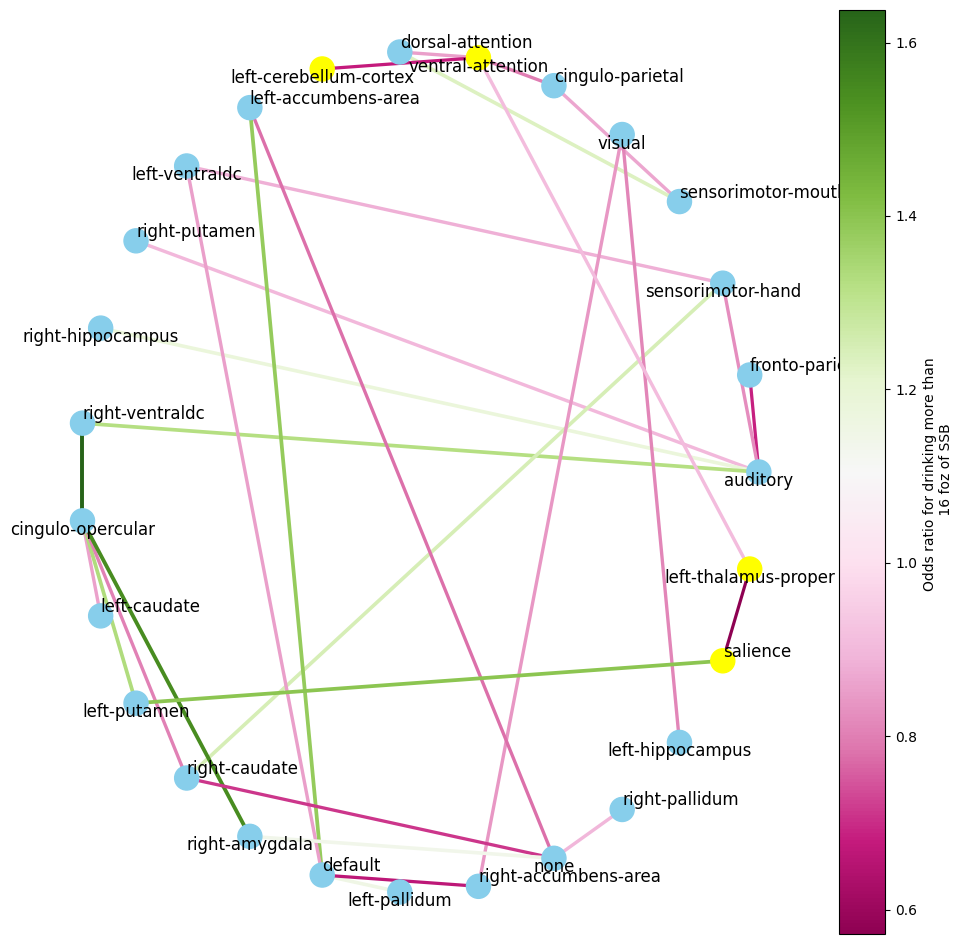

In [204]:
plt.figure(figsize=(12, 12))  # Increase the size as needed

# Your existing code for coloring nodes based on 'bootP' and setting up edge colors and widths

# Assuming default_color is defined somewhere in your code
default_color = "skyblue"  # Example, replace with your actual default color

# Draw nodes and edges, but without labels this time
nx.draw_networkx_nodes(H, pos, node_color=node_colors)
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=edge_widths)

# Custom function to draw labels with alternating alignments
def draw_custom_labels(graph, positions):
    for index, (node, (x, y)) in enumerate(positions.items()):
        # Alternate alignment
        if index % 2 == 0:
            verticalalignment = "top"
            horizontalalignment = "center"
        else:
            verticalalignment = "bottom"
            horizontalalignment = "left"
        
        plt.text(x, y, node,
                 fontsize=12,
                 verticalalignment=verticalalignment,
                 horizontalalignment=horizontalalignment)

# Draw labels with custom alignments
draw_custom_labels(H, pos)

plt.axis('off')  # Hide axes
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=plt.gca(), orientation='vertical', 
             label='Odds ratio for drinking more than \n 16 foz of SSB')
plt.savefig(os.path.join(basepath,'my_network_graph.png'), format='png', bbox_inches='tight', dpi=300)  # Ensure 'your_directory_path' is defined
plt.show()

In [188]:
# Save the figure to a file
plt.savefig(os.path.join(basepath,'my_network_graph.png'), format='png', bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

### Sklearn

In [82]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#y_aligned, X_aligned
logisticRegr = LogisticRegression()
logisticRegr.fit(X_aligned, y_aligned)

df=pd.DataFrame({'odds_ratio':(np.exp(logisticRegr.coef_).T).tolist(),'variable':X_aligned.columns.tolist()})
df['odds_ratio'] = df['odds_ratio'].str.get(0)

df=df.sort_values('odds_ratio', ascending=False)
df

,odds_ratio,variable
21,1.913509,rsfmri_cor_ngd_cerc_scs_vtdcrh
24,1.771368,rsfmri_cor_ngd_df_scs_aalh
17,1.697046,rsfmri_cor_ngd_cerc_scs_ptlh
20,1.683711,rsfmri_cor_ngd_cerc_scs_agrh
15,1.494967,rsfmri_cor_ngd_au_scs_vtdcrh
42,1.456509,rsfmri_cor_ngd_smh_scs_cderh
47,1.452884,rsfmri_cor_ngd_sa_scs_ptlh
6,1.350545,rsfmri_c_ngd_dla_ngd_smm
14,1.251509,rsfmri_cor_ngd_au_scs_hprh
29,1.233470,rsfmri_cor_ngd_none_scs_ptlh


In [83]:
from sklearn.utils import resample
import numpy as np

# Define the number of bootstrap samples
n_bootstraps = 1000
coef_matrix = []
#y_aligned, X_aligned
# Bootstrap loop
for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_aligned, y_aligned)
    logisticRegr.fit(X_sample, y_sample)
    coef_matrix.append(logisticRegr.coef_[0])

# Convert to numpy array for ease of calculation
coef_matrix = np.array(coef_matrix)

# Calculating percentiles for 95% confidence intervals
lower_bounds = np.percentile(coef_matrix, 2.5, axis=0)
upper_bounds = np.percentile(coef_matrix, 97.5, axis=0)

# Assuming you have a DataFrame 'df' with your coefficients and variable names
df['lower_ci'] = lower_bounds
df['upper_ci'] = upper_bounds

In [84]:
df

,odds_ratio,variable,lower_ci,upper_ci
21,1.913509,rsfmri_cor_ngd_cerc_scs_vtdcrh,-1.269923,0.120424
24,1.771368,rsfmri_cor_ngd_df_scs_aalh,-1.102393,0.641146
17,1.697046,rsfmri_cor_ngd_cerc_scs_ptlh,-0.821854,0.576359
20,1.683711,rsfmri_cor_ngd_cerc_scs_agrh,-0.684615,0.857304
15,1.494967,rsfmri_cor_ngd_au_scs_vtdcrh,-0.929658,0.446811
42,1.456509,rsfmri_cor_ngd_smh_scs_cderh,-0.998542,0.269714
47,1.452884,rsfmri_cor_ngd_sa_scs_ptlh,-0.409844,0.935676
6,1.350545,rsfmri_c_ngd_dla_ngd_smm,-0.856593,0.404608
14,1.251509,rsfmri_cor_ngd_au_scs_hprh,-1.182269,0.494157
29,1.233470,rsfmri_cor_ngd_none_scs_ptlh,-0.860636,0.861382


In [ ]:
print(significant_features)
